## Device check

In [1]:
!nvidia-smi

Sun Oct 29 11:08:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   29C    P0    41W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Packages

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [3]:

import lightning.pytorch as pl
import logging
logging.basicConfig(level="INFO")

import math
from matplotlib import pyplot

import numpy as np

import os

import pandas as pd
from pprint import pprint

import sys
sys.path.append("../src")

import timm
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
%load_ext autoreload
%autoreload 2

In [398]:
import config
from dataloader import BEDataset, BEDataModule
import token_learner
from transformer import PositionalEncoder, SelfAttentionHead, MultiHeadSelfAttention, FeedFowardLayer, LayerNormalization, TransformerDecoderLayer, TransformerDecoder, generate_causal_attention_mask

from film_layers import FiLMBlockV2, FiLMEncoder, ResBlockDWConv
from rt1 import RT1Encoder, RT1Decoder, ActionGenerator
from utils.data_utils import History
from utils.model_utils import TextEncoder, ImageFeatureExtractor, plot_attention


## Data Module

In [232]:
dm = BEDataModule()
dm.setup()

INFO:root:Training on 3915 samples.
INFO:root:Validating on 961 samples.
INFO:root:Testing on 250 samples.


Total # examples: 5126


## Fetch batch

In [276]:
sample = next(iter(dm.test_dataloader()))
print(sample.keys())
sample["in_state"].shape

dict_keys(['sample_id', 'in_state', 'action_desc', 'source_mask'])


torch.Size([4, 3, 288, 288])

In [277]:
%%time
sample = next(iter(dm.train_dataloader()))
print(sample.keys())
sample["in_state"].shape

dict_keys(['sample_id', 'in_state', 'action_desc', 'source_mask', 'motor_cmd', 'target_mask'])
CPU times: user 15.1 ms, sys: 192 ms, total: 207 ms
Wall time: 798 ms


torch.Size([4, 3, 288, 288])

In [278]:
sample["source_mask"].shape, sample["target_mask"].shape

(torch.Size([4, 1, 48]), torch.Size([4, 1, 16, 16]))

## Model Design

<!-- ![RT1 model architecture](../../imgs/rt1+.png) -->
<center>
    <img src="../imgs/rt1+.png" alt="RT1 model architecture" width="300" height="400">

<center>

### Encoder

#### Test Text Encoder

In [110]:
# te = TextEncoder(freeze=True).cuda()
# summary(model=te, col_names=["num_params", "trainable"])

In [109]:
# emb = te(
#     inp_ids=sample["action_desc"]["ids"].cuda(),
#     mask=sample["action_desc"]["mask"].cuda(),
#     tok_type_ids=sample["action_desc"]["token_type_ids"].cuda()
# )

# emb.shape

torch.Size([4, 512])

#### Test Img Feature Extractor

In [ ]:
# fe = ImageFeatureExtractor(pretrained=True, arch="efficientnet_b3").cuda()

# summary(fe, col_names=["num_params", "trainable"])

In [ ]:
# img_ftrs = fe(sample["in_state"].cuda())

# img_ftrs.shape

#### Test FiLM Block

In [16]:
# film_block = FiLMBlockV2().cuda()
# print(film_block)
# summary(model=film_block)

In [17]:
# text_cond_ftrs = film_block(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs.shape

#### Test Residual FiLM Block

In [18]:
# dw_res = ResBlockDWConv(512, 512).cuda()
# summary(model=dw_res)

In [19]:
# text_cond_ftrs_res = dw_res(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs_res.shape

#### Test FiLM Encoder

In [20]:
# film_encoder = FiLMEncoder(
#     arch="resnet34",
#     n_res_blocks=6,
# ).cuda()

# # print(film_encoder)
# summary(model=film_encoder)

In [21]:
# %%time

# out = film_encoder(
#     x= sample["in_state"].cuda(),
#     conditioning= emb
# )

# out.shape

#### Token Learner

In [22]:
# N, C, H_W = out.shape
# N, C, H_W

In [23]:
# tokL_v11 = token_learner.TokenLearnerModuleV11(feature_shape=(N, H_W, C)).cuda()
# print(tokL_v11)
# summary(model=tokL_v11)

In [24]:
# learned_tokens = tokL_v11(out.view(N, H_W, C))
# learned_tokens.shape

In [154]:
tokenized_inputs = torch.empty((B, config.NUM_HISTORY+1, config.D_MODEL, config.NUM_LEARNED_TOKENS))
tokenized_inputs.shape

torch.Size([8, 6, 512, 8])

#### RT-1 Encoder

In [14]:
encoder = RT1Encoder(
    cnn_bacnbone="efficientnet_b3", 
    num_res_blocks=6, 
    freeze_cnn_backbone=True
).to(config.DEVICE)

summary(model=encoder, col_names=["num_params", "trainable"])

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b3.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b3.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Layer (type:depth-idx)                                       Param #                   Trainable
RT1Encoder                                                   --                        Partial
├─TextEncoder: 1-1                                           --                        False
│    └─BertModel: 2-1                                        --                        False
│    │    └─BertEmbeddings: 3-1                              (15,891,456)              False
│    │    └─BertEncoder: 3-2                                 (12,609,536)              False
│    │    └─BertPooler: 3-3                                  (262,656)                 False
│    └─Dropout: 2-2                                          --                        --
├─FiLMEncoder: 1-2                                           --                        Partial
│    └─ImageFeatureExtractor: 2-3                            --                        Partial
│    │    └─EfficientNetFeatures: 3-4                        (1

In [15]:
%%time 

src_enc, tokens = encoder._encode(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

src_enc.shape, tokens.shape

CPU times: user 842 ms, sys: 944 ms, total: 1.79 s
Wall time: 9.13 s


(torch.Size([4, 512]), torch.Size([4, 512, 8]))

In [16]:
%%time

src_enc, tokenized_inputs = encoder(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

tokenized_inputs.shape, tokenized_inputs.device

CPU times: user 199 ms, sys: 41.8 ms, total: 241 ms
Wall time: 1.24 s


(torch.Size([4, 48, 512]), device(type='cuda', index=0))

### Decoder

In [17]:
pos_encoding = PositionalEncoder(seq_len=config.NUM_TOKENIZED_INPUTS).cuda()

In [18]:
pos_enc = pos_encoding(tokenized_inputs)
print(pos_enc.shape)

learned_tokens = tokenized_inputs + pos_enc

torch.Size([4, 48, 512])


In [74]:
inp_embedding = encoder.text_encoder.text_encoder.embeddings

target_embedding = nn.Embedding(
    num_embeddings=config.TARGET_VOCAB_SIZE, 
    embedding_dim=config.EMBEDDING_DIM, 
    padding_idx=config.TGT_PAD_TOK_ID
).cuda()

In [75]:
inp = sample["action_desc"]["ids"].cuda()
outp = sample["motor_cmd"]["decoder_inp_ids"].cuda()

inp_emb = inp_embedding(inp)
outp_emb = target_embedding(outp)

inp_emb.shape, outp_emb.shape

(torch.Size([4, 16, 512]), torch.Size([4, 16, 512]))

#### Test MultiHead Self-Attention Layer

In [248]:
# sa = SelfAttentionHead().cuda()
# sa.eval()
# print(sa)
# summary(sa)

In [298]:
# %%time

# mem, attn_w = sa(
#     q=inp_emb, 
#     k=inp_emb, 
#     v=inp_emb, 
#     mask=sample["target_mask"].cuda(),
#     return_weights=True
# )

# mem.shape, attn_w.shape

CPU times: user 2.38 ms, sys: 5 ms, total: 7.38 ms
Wall time: 209 ms


(torch.Size([4, 16, 512]), torch.Size([4, 16, 16]))

In [250]:
# plot_attention(attn_w)

In [251]:
mhsa = MultiHeadSelfAttention(num_heads=4).cuda()
mhsa.eval()
print(mhsa)
summary(mhsa)

MultiHeadSelfAttention(
  (attention_heads): ModuleList(
    (0-3): 4 x SelfAttentionHead(
      (dropout): Dropout(p=0.1, inplace=False)
      (_softmax): Softmax(dim=-1)
      (w_q): Linear(in_features=512, out_features=512, bias=False)
      (w_k): Linear(in_features=512, out_features=512, bias=False)
      (w_v): Linear(in_features=512, out_features=512, bias=False)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=False)
    (1): Dropout(p=0.1, inplace=False)
  )
)


Layer (type:depth-idx)                   Param #
MultiHeadSelfAttention                   --
├─ModuleList: 1-1                        --
│    └─SelfAttentionHead: 2-1            --
│    │    └─Dropout: 3-1                 --
│    │    └─Softmax: 3-2                 --
│    │    └─Linear: 3-3                  262,144
│    │    └─Linear: 3-4                  262,144
│    │    └─Linear: 3-5                  262,144
│    └─SelfAttentionHead: 2-2            --
│    │    └─Dropout: 3-6                 --
│    │    └─Softmax: 3-7                 --
│    │    └─Linear: 3-8                  262,144
│    │    └─Linear: 3-9                  262,144
│    │    └─Linear: 3-10                 262,144
│    └─SelfAttentionHead: 2-3            --
│    │    └─Dropout: 3-11                --
│    │    └─Softmax: 3-12                --
│    │    └─Linear: 3-13                 262,144
│    │    └─Linear: 3-14                 262,144
│    │    └─Linear: 3-15                 262,144
│    └─SelfAttentionHead: 

In [279]:
%%time

mem, attn_w = mhsa(
    q=inp_emb, 
    k=inp_emb, 
    v=inp_emb, 
    mask=sample["target_mask"].cuda(),
    return_weights=True
)

mem.shape, attn_w.shape

CPU times: user 2.73 ms, sys: 79 µs, total: 2.81 ms
Wall time: 2.28 ms


(torch.Size([4, 16, 512]), torch.Size([4, 4, 16, 16]))

In [280]:
attn_w[0, 0, 0]

tensor([0.0606, 0.0543, 0.0559, 0.0649, 0.0481, 0.0547, 0.0406, 0.0551, 0.0659,
        0.0666, 0.0759, 0.0744, 0.0740, 0.0715, 0.0697, 0.0679],
       device='cuda:0', grad_fn=<SelectBackward0>)

#### Plot Self-attention weights

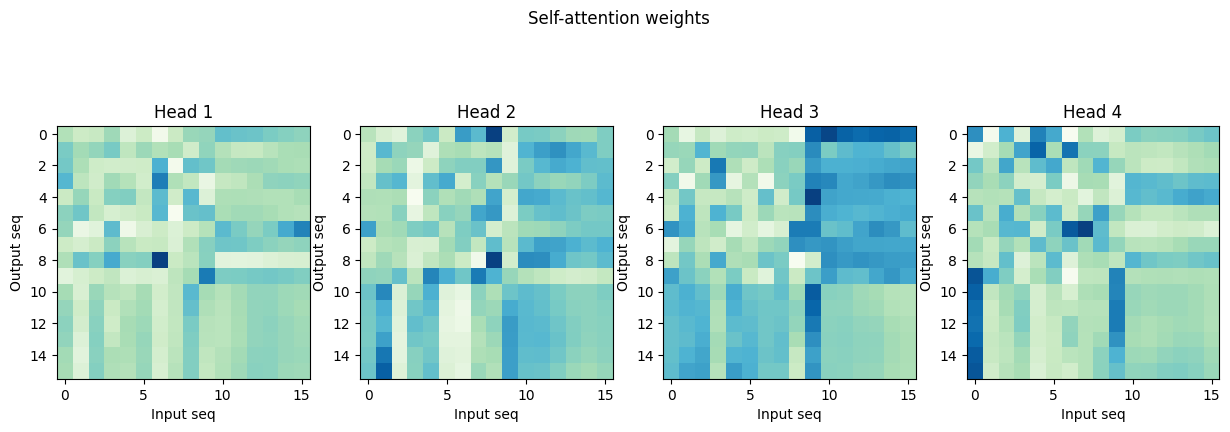

In [281]:
plot_attention(attn_w)
# plot_attention(attn_w, example_idx=2)

#### Test Cross Attention Layer

In [282]:
num_heads = 2

cross_attention = MultiHeadSelfAttention(
    num_heads=num_heads
).cuda()

cross_attention.eval()
print(cross_attention)
summary(cross_attention)

MultiHeadSelfAttention(
  (attention_heads): ModuleList(
    (0-1): 2 x SelfAttentionHead(
      (dropout): Dropout(p=0.1, inplace=False)
      (_softmax): Softmax(dim=-1)
      (w_q): Linear(in_features=512, out_features=512, bias=False)
      (w_k): Linear(in_features=512, out_features=512, bias=False)
      (w_v): Linear(in_features=512, out_features=512, bias=False)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=False)
    (1): Dropout(p=0.1, inplace=False)
  )
)


Layer (type:depth-idx)                   Param #
MultiHeadSelfAttention                   --
├─ModuleList: 1-1                        --
│    └─SelfAttentionHead: 2-1            --
│    │    └─Dropout: 3-1                 --
│    │    └─Softmax: 3-2                 --
│    │    └─Linear: 3-3                  262,144
│    │    └─Linear: 3-4                  262,144
│    │    └─Linear: 3-5                  262,144
│    └─SelfAttentionHead: 2-2            --
│    │    └─Dropout: 3-6                 --
│    │    └─Softmax: 3-7                 --
│    │    └─Linear: 3-8                  262,144
│    │    └─Linear: 3-9                  262,144
│    │    └─Linear: 3-10                 262,144
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       524,288
│    └─Dropout: 2-4                      --
Total params: 2,097,152
Trainable params: 2,097,152
Non-trainable params: 0

In [283]:
%%time

cross_attn_mem, cross_attn_w = cross_attention(
    q=inp_emb, 
    k=learned_tokens, 
    v=learned_tokens, 
    mask=sample["source_mask"].cuda(),
    return_weights=True
)

cross_attn_mem.shape, cross_attn_w.shape

CPU times: user 793 µs, sys: 864 µs, total: 1.66 ms
Wall time: 1.33 ms


(torch.Size([4, 16, 512]), torch.Size([4, 2, 16, 48]))

#### Plot Cross attention weights

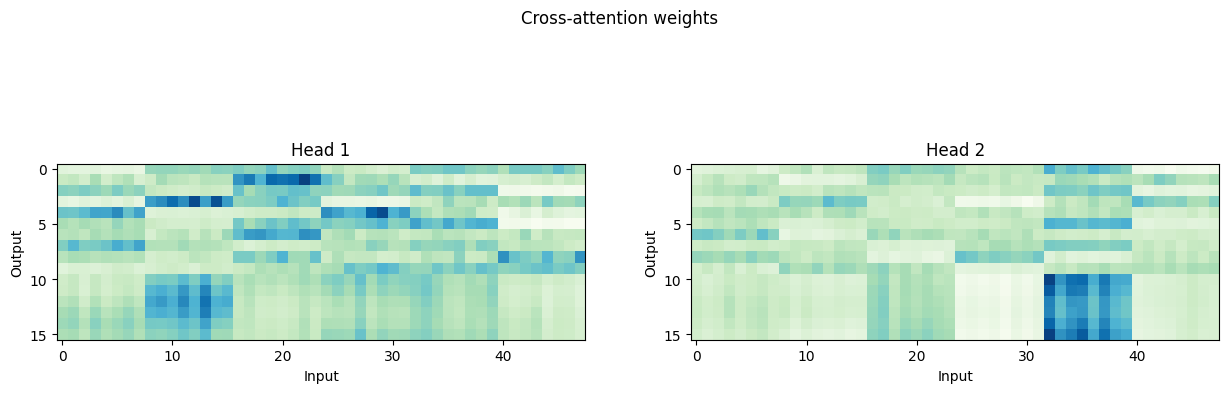

In [284]:
plot_attention(cross_attn_w)
# plot_attention(cross_attn_w, example_idx=2)

#### Test Transformer decoder layer

In [361]:
dec_layer = TransformerDecoderLayer().cuda()
print(dec_layer)
dec_layer.eval()
summary(dec_layer)

TransformerDecoderLayer(
  (self_attn): MultiHeadSelfAttention(
    (attention_heads): ModuleList(
      (0-3): 4 x SelfAttentionHead(
        (dropout): Dropout(p=0.1, inplace=False)
        (_softmax): Softmax(dim=-1)
        (w_q): Linear(in_features=512, out_features=512, bias=False)
        (w_k): Linear(in_features=512, out_features=512, bias=False)
        (w_v): Linear(in_features=512, out_features=512, bias=False)
      )
    )
    (output_layer): Sequential(
      (0): Linear(in_features=2048, out_features=512, bias=False)
      (1): Dropout(p=0.1, inplace=False)
    )
  )
  (cross_attn): MultiHeadSelfAttention(
    (attention_heads): ModuleList(
      (0-3): 4 x SelfAttentionHead(
        (dropout): Dropout(p=0.1, inplace=False)
        (_softmax): Softmax(dim=-1)
        (w_q): Linear(in_features=512, out_features=512, bias=False)
        (w_k): Linear(in_features=512, out_features=512, bias=False)
        (w_v): Linear(in_features=512, out_features=512, bias=False)
      )

Layer (type:depth-idx)                   Param #
TransformerDecoderLayer                  --
├─MultiHeadSelfAttention: 1-1            --
│    └─ModuleList: 2-1                   --
│    │    └─SelfAttentionHead: 3-1       786,432
│    │    └─SelfAttentionHead: 3-2       786,432
│    │    └─SelfAttentionHead: 3-3       786,432
│    │    └─SelfAttentionHead: 3-4       786,432
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-5                  1,048,576
│    │    └─Dropout: 3-6                 --
├─MultiHeadSelfAttention: 1-2            --
│    └─ModuleList: 2-3                   --
│    │    └─SelfAttentionHead: 3-7       786,432
│    │    └─SelfAttentionHead: 3-8       786,432
│    │    └─SelfAttentionHead: 3-9       786,432
│    │    └─SelfAttentionHead: 3-10      786,432
│    └─Sequential: 2-4                   --
│    │    └─Linear: 3-11                 1,048,576
│    │    └─Dropout: 3-12                --
├─LayerNormalization: 1-3                --
│    └─LayerNorm:

In [339]:
dec_out, self_attn_w, cross_attn_w = dec_layer(
    inp=inp_emb, 
    encoder_out=learned_tokens, 
    src_mask=sample["source_mask"].cuda(), 
    target_mask=sample["target_mask"].cuda(), 
    debug=False
)
dec_out.shape, self_attn_w.shape, cross_attn_w.shape

(torch.Size([4, 16, 512]),
 torch.Size([4, 4, 16, 16]),
 torch.Size([4, 4, 16, 48]))

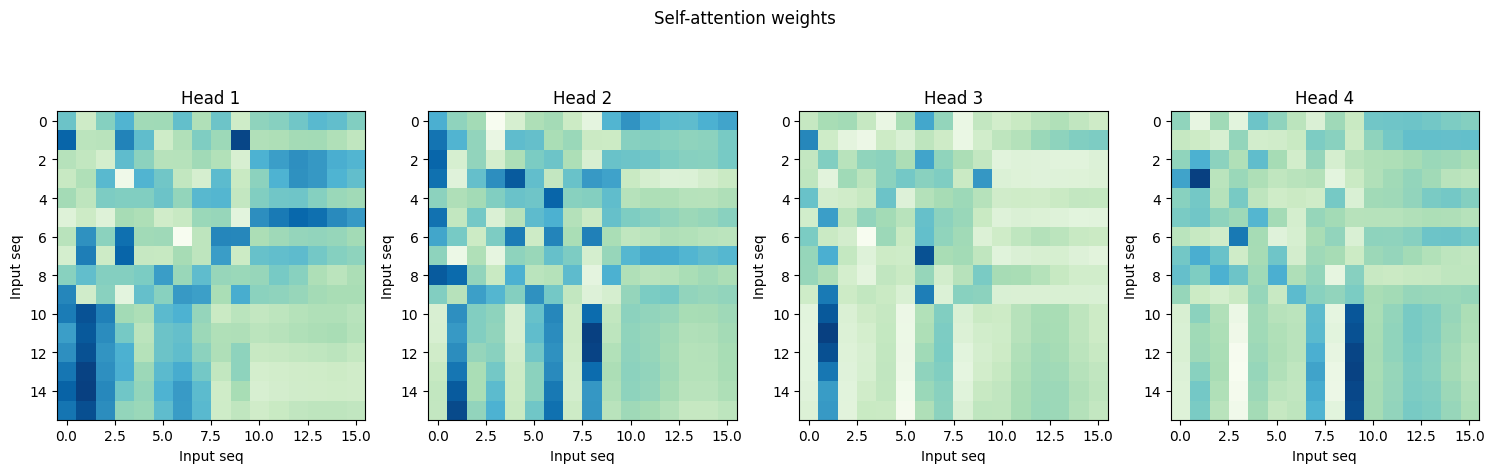

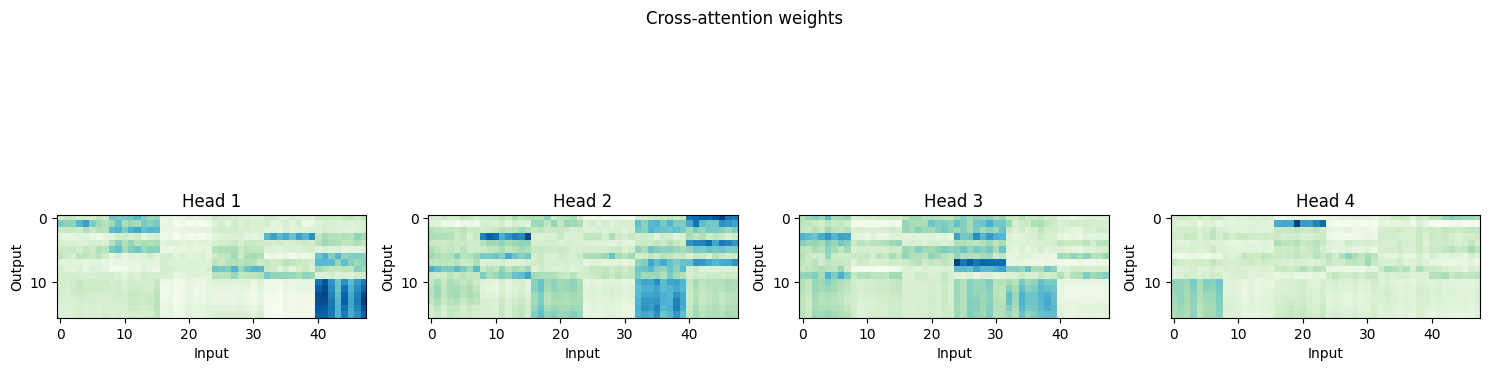

In [340]:
plot_attention(self_attn_w)
plot_attention(cross_attn_w)

#### Test Transformer decoder

In [367]:
dec = TransformerDecoder(num_layers=2).cuda()
print(dec)
dec.eval()
summary(model=dec)

TransformerDecoder(
  (layers): ModuleList(
    (0-1): 2 x TransformerDecoderLayer(
      (self_attn): MultiHeadSelfAttention(
        (attention_heads): ModuleList(
          (0-3): 4 x SelfAttentionHead(
            (dropout): Dropout(p=0.1, inplace=False)
            (_softmax): Softmax(dim=-1)
            (w_q): Linear(in_features=512, out_features=512, bias=False)
            (w_k): Linear(in_features=512, out_features=512, bias=False)
            (w_v): Linear(in_features=512, out_features=512, bias=False)
          )
        )
        (output_layer): Sequential(
          (0): Linear(in_features=2048, out_features=512, bias=False)
          (1): Dropout(p=0.1, inplace=False)
        )
      )
      (cross_attn): MultiHeadSelfAttention(
        (attention_heads): ModuleList(
          (0-3): 4 x SelfAttentionHead(
            (dropout): Dropout(p=0.1, inplace=False)
            (_softmax): Softmax(dim=-1)
            (w_q): Linear(in_features=512, out_features=512, bias=False)
  

Layer (type:depth-idx)                             Param #
TransformerDecoder                                 --
├─ModuleList: 1-1                                  --
│    └─TransformerDecoderLayer: 2-1                --
│    │    └─MultiHeadSelfAttention: 3-1            4,194,304
│    │    └─MultiHeadSelfAttention: 3-2            4,194,304
│    │    └─LayerNormalization: 3-3                1,024
│    │    └─LayerNormalization: 3-4                1,024
│    │    └─Sequential: 3-5                        2,099,712
│    │    └─LayerNorm: 3-6                         1,024
│    │    └─Dropout: 3-7                           --
│    └─TransformerDecoderLayer: 2-2                --
│    │    └─MultiHeadSelfAttention: 3-8            4,194,304
│    │    └─MultiHeadSelfAttention: 3-9            4,194,304
│    │    └─LayerNormalization: 3-10               1,024
│    │    └─LayerNormalization: 3-11               1,024
│    │    └─Sequential: 3-12                       2,099,712
│    │    └─LayerNor

#### Test Transformer Decoder

In [368]:
dec_out, self_attn_ws, cross_attn_ws = dec(
    inp=inp_emb, 
    encoder_out=learned_tokens, 
    src_mask=sample["source_mask"].cuda(), 
    target_mask=sample["target_mask"].cuda(), 
    debug=False
)

dec_out.shape, self_attn_ws.shape, cross_attn_ws.shape

(torch.Size([4, 16, 512]),
 torch.Size([4, 2, 4, 16, 16]),
 torch.Size([4, 2, 4, 16, 48]))

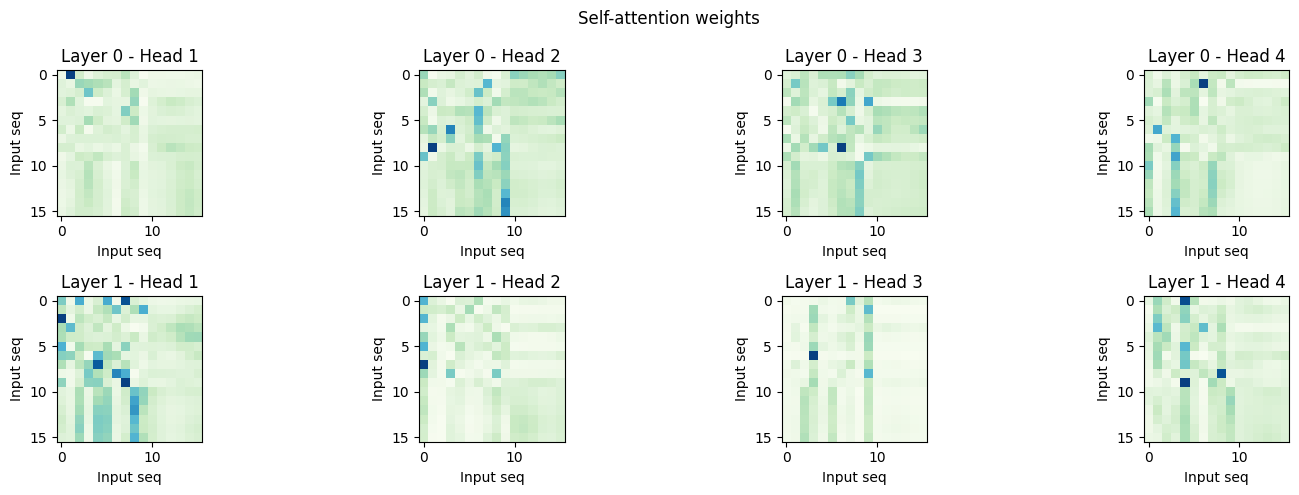

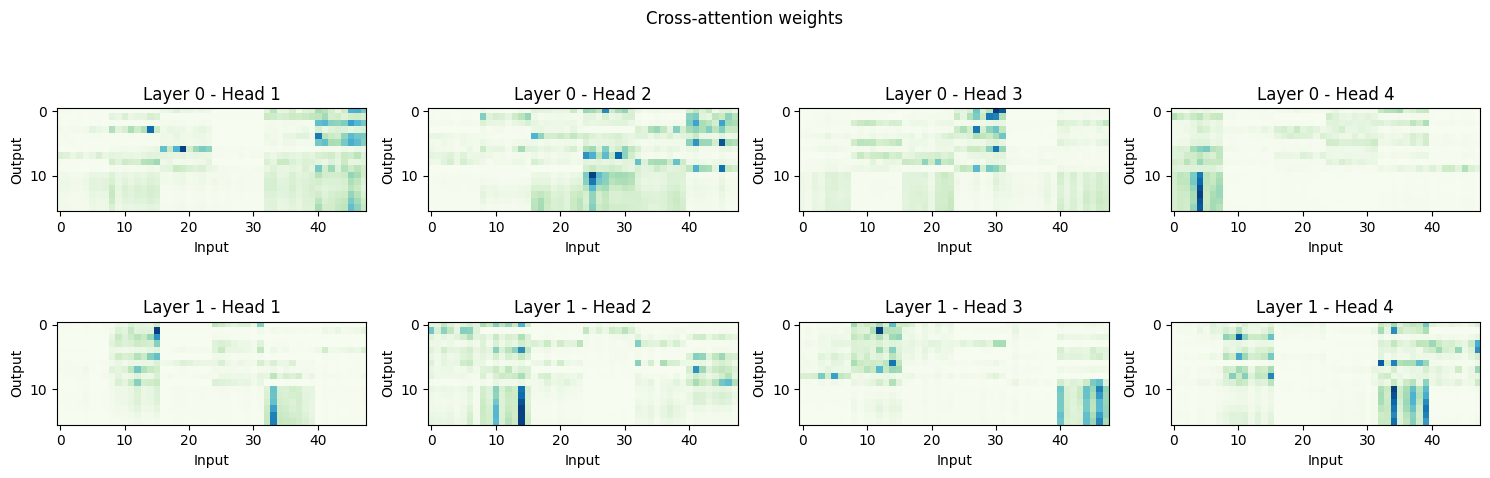

In [369]:
plot_attention(self_attn_ws)
plot_attention(cross_attn_ws)

#### Action Generator

In [390]:
generator = ActionGenerator().cuda()
print(generator)
summary(generator)

ActionGenerator(
  (proj): Sequential(
    (0): Linear(in_features=512, out_features=52, bias=True)
    (1): Dropout(p=0.15, inplace=False)
  )
  (_softmax): LogSoftmax(dim=-1)
)


Layer (type:depth-idx)                   Param #
ActionGenerator                          --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       26,676
│    └─Dropout: 2-2                      --
├─LogSoftmax: 1-2                        --
Total params: 26,676
Trainable params: 26,676
Non-trainable params: 0

In [392]:
preds = generator(dec_out)
preds.shape

torch.Size([4, 16, 52])

In [393]:
predicted_next_tok = preds[:, -1, :].argmax(dim=-1)
predicted_next_tok.shape, predicted_next_tok

(torch.Size([4]), tensor([5, 5, 5, 5], device='cuda:0'))

### RT-1 Decoder

In [399]:
decoder = RT1Decoder(num_decoder_layers=1).cuda()
print(decoder)
decoder.eval()
summary(model=decoder)

RT1Decoder(
  (target_embedding): Embedding(52, 512, padding_idx=0)
  (token_embedding): Linear(in_features=512, out_features=512, bias=False)
  (pos_embedding): PositionalEncoder()
  (transformer): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiHeadSelfAttention(
          (attention_heads): ModuleList(
            (0-3): 4 x SelfAttentionHead(
              (dropout): Dropout(p=0.15, inplace=False)
              (_softmax): Softmax(dim=-1)
              (w_q): Linear(in_features=512, out_features=512, bias=False)
              (w_k): Linear(in_features=512, out_features=512, bias=False)
              (w_v): Linear(in_features=512, out_features=512, bias=False)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=2048, out_features=512, bias=False)
            (1): Dropout(p=0.15, inplace=False)
          )
        )
        (cross_attn): MultiHeadSelfAttention(
          (atten

Layer (type:depth-idx)                                  Param #
RT1Decoder                                              --
├─Embedding: 1-1                                        26,624
├─Linear: 1-2                                           262,144
├─PositionalEncoder: 1-3                                --
├─TransformerDecoder: 1-4                               --
│    └─ModuleList: 2-1                                  --
│    │    └─TransformerDecoderLayer: 3-1                10,491,392
├─LayerNormalization: 1-5                               --
│    └─LayerNorm: 2-2                                   1,024
├─ActionGenerator: 1-6                                  --
│    └─Sequential: 2-3                                  --
│    │    └─Linear: 3-2                                 26,676
│    │    └─Dropout: 3-3                                --
│    └─LogSoftmax: 2-4                                  --
Total params: 10,807,860
Trainable params: 10,807,860
Non-trainable params: 0

In [400]:
%time

preds, self_attn_ws, cross_attn_ws = decoder(
    inp=sample["motor_cmd"]["decoder_inp_ids"].cuda(), 
    encoder_out=learned_tokens, 
    src_mask=sample["source_mask"].cuda(), 
    target_mask=sample["target_mask"].cuda(), 
    debug=False
)

preds.shape, self_attn_ws.shape, cross_attn_ws.shape

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


(torch.Size([4, 16, 52]),
 torch.Size([4, 1, 4, 16, 16]),
 torch.Size([4, 1, 4, 16, 48]))

### RT-1 

In [ ]:
class RT1(pl.LightningModule):
    def __init__(
        self
    ):
        super().__init__()
        self.encoder = RT1Encder()
        self.decoder = RT1Decoder()
        
    def forward(self, input_ids, attn_mask, token_type_ids, imgs):
        
        tokens = self.encode(input_ids, attn_mask, token_type_ids, imgs)
        pass
    
    def encode(self, input_ids, attn_mask, token_type_ids, imgs):
        return self.encoder(input_ids, attn_mask, token_type_ids, imgs)
    
    def decode(        
        self, 
        inp:torch.Tensor, 
        encoder_out:torch.Tensor,
        src_mask:torch.Tensor=None, 
        target_mask:torch.tensor=None,
        return_weights:bool=True,
        debug:bool=False
    ):
        return self.decoder(y, enc_outputs, src_mask, tgt_mask)
    
    def configure_optimizers(self):
        pass
    
    def training_step(self, batch, batch_idx):
        pass
    
    def validation_step(self, batch, batch_idx):
        pass
    
    def test_step(self, batch, batch_idx):
        pass
    
    def compute_loss(self, outputs, targets):
        pass